# Convnet demo

## Preliminaries

In [1]:
import logging
import numpy as np
import deeppy as dp
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

def plot_img(img, title, figsize=(6,6)):
    plt.figure(figsize=figsize)
    plt.imshow(img, interpolation='nearest', cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()

# Log to notebook
log = logging.getLogger()
for handler in log.handlers:
    log.removeHandler(handler)
    handler = logging.StreamHandler()
    log.addHandler(handler)
    handler.setFormatter(logging.Formatter('%(message)s'))
    log.setLevel(logging.INFO)

## Prepare input data

In [2]:
# Fetch CIFAR10 data
dataset = dp.dataset.CIFAR10()
x_train, y_train, x_test, y_test = dataset.data(dp_dtypes=True)

# Normalize pixel intensities
scaler = dp.StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# Prepare network inputs
batch_size = 128
train_input = dp.SupervisedInput(x_train, y_train, batch_size=batch_size)
test_input = dp.Input(x_test, batch_size=batch_size)

## Plot dataset examples

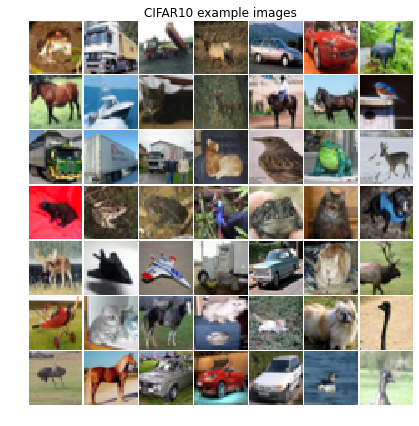

In [3]:
img_bhwc = np.transpose(x_train[:49], (0, 2, 3, 1))
img_tile = dp.misc.img_tile(dp.misc.img_stretch(img_bhwc), border_color=1.0)
plot_img(img_tile, title='CIFAR10 example images')

## Setup network

In [4]:
filler = dp.AutoFiller(gain=1.25)
def conv_layer(n_filters, filter_size):
    return dp.Convolution(
        n_filters=n_filters,
        filter_shape=(filter_size, filter_size),
        border_mode='same',
        weights=dp.Parameter(filler, weight_decay=0.003),
    )

def pool_layer():
    return dp.Pool(
        win_shape=(3, 3),
        strides=(2, 2),
        border_mode='same',
        method='avg',
    )

net = dp.NeuralNetwork(
    layers=[
        conv_layer(32, 7),
        dp.ReLU(),
        pool_layer(),
        conv_layer(32, 5),
        dp.ReLU(),
        pool_layer(),
        conv_layer(64, 5),
        dp.ReLU(),
        pool_layer(),
        dp.Flatten(),
        dp.FullyConnected(
            n_out=64,
            weights=dp.Parameter(filler, weight_decay=0.03)
        ),
        dp.ReLU(),
        dp.FullyConnected(
            n_out=dataset.n_classes,
            weights=dp.Parameter(filler),
        )
    ],
    loss=dp.SoftmaxCrossEntropy(),
)

## Plot gradients

In [5]:
batches_input = dp.SupervisedInput(x_train, y_train, batch_size=32)
net._setup(batches_input.x_shape)
batches = batches_input.batches()

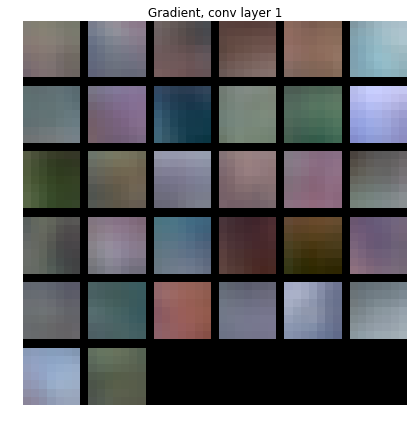

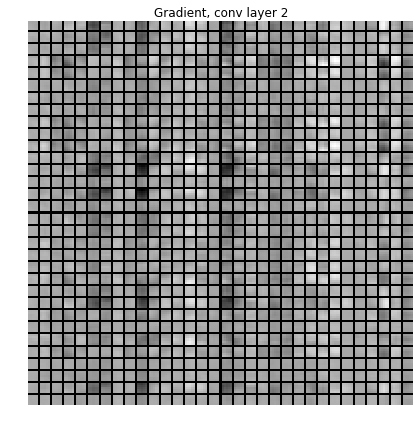

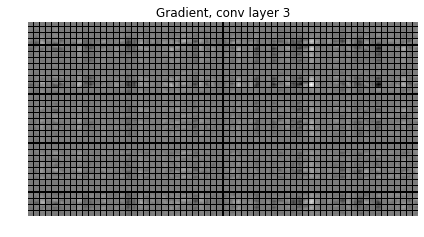

In [6]:
loss = net._update(**batches.next())

# Plot convolutional filters.
filters = [l.weights.grad_array for l in net.layers
           if isinstance(l, dp.Convolution)]

for i, f in enumerate(filters):
    plot_img(dp.misc.conv_filter_tile(f), title='Gradient, conv layer %i' % (i+1))

## Plot convolutional filters

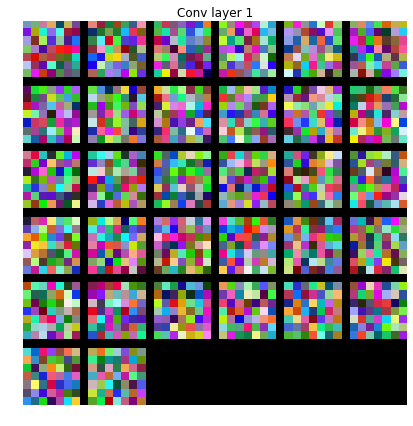

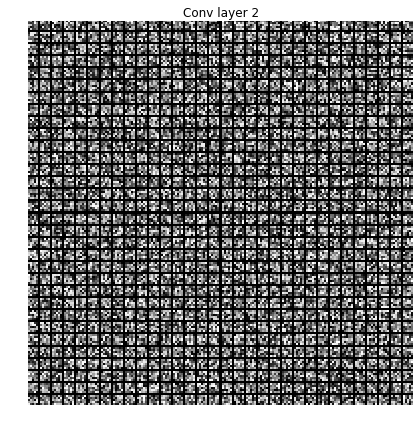

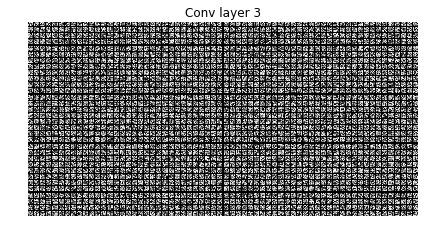

In [7]:
filters = [l.weights.array for l in net.layers
           if isinstance(l, dp.Convolution)]

for i, f in enumerate(filters):
    plot_img(dp.misc.conv_filter_tile(f), title='Conv layer %i' % (i+1))

## Train convnet

In [8]:
n_epochs = [8, 5]
learn_rate = 0.04
for i, max_epochs in enumerate(n_epochs):
    lr = learn_rate/10**i
    trainer = dp.StochasticGradientDescent(
        max_epochs=max_epochs,
        learn_rule=dp.Momentum(learn_rate=lr, momentum=0.9),
    )
    trainer.train(net, train_input)

SGD: Model contains 147882 parameters.
SGD: 391 gradient updates per epoch.
epoch 1/5, cost 1.825137
epoch 2/5, cost 1.367858
epoch 3/5, cost 1.149958
epoch 4/6, cost 1.012772
epoch 5/7, cost 0.910101
epoch 6/9, cost 0.830212
epoch 7/10, cost 0.770296
epoch 8/12, cost 0.732689
SGD: Stopped by max_epochs.
SGD: Optimization ran for 1.13 minutes (8 epochs, 8.5 s/epoch)
SGD: Model contains 147882 parameters.
SGD: 391 gradient updates per epoch.
epoch 1/5, cost 0.561007
epoch 2/5, cost 0.504403
epoch 3/5, cost 0.475621
epoch 4/6, cost 0.452976
epoch 5/7, cost 0.433307
SGD: Stopped by max_epochs.
SGD: Optimization ran for 0.73 minutes (5 epochs, 8.8 s/epoch)


## Evaluate convnet on test set

In [9]:
def test_error():
    return np.mean(net.predict(test_input) != y_test)

print('Test error rate: %.4f' % test_error())

Test error rate: 0.2639


## Plot layer-wise outputs

In [10]:
batches_input = dp.SupervisedInput(x_train, y_train, batch_size=1)
batches = batches_input.batches()

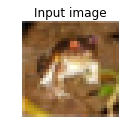

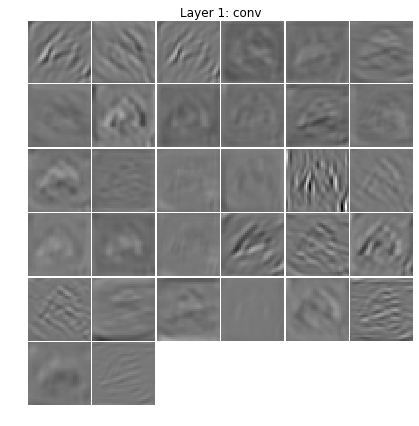

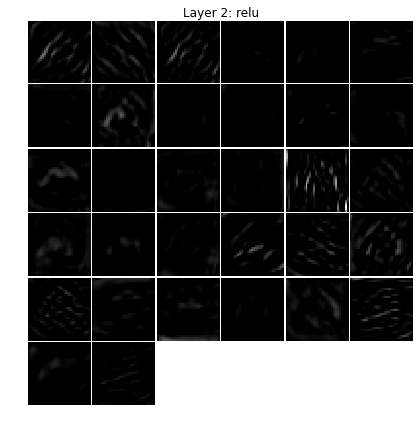

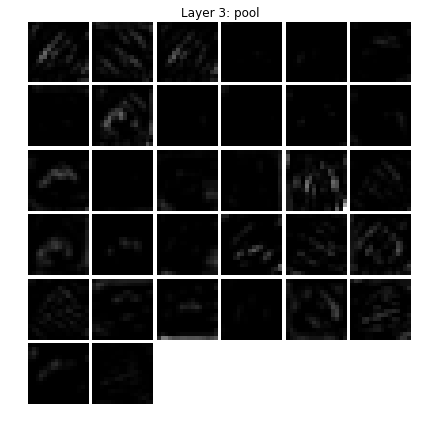

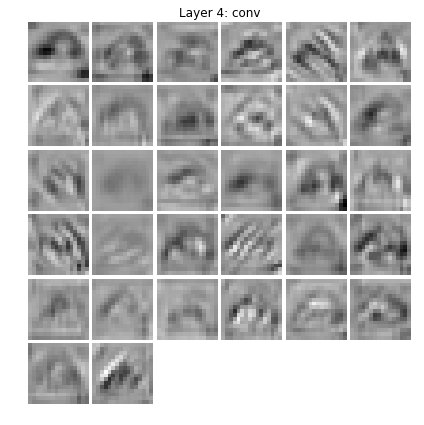

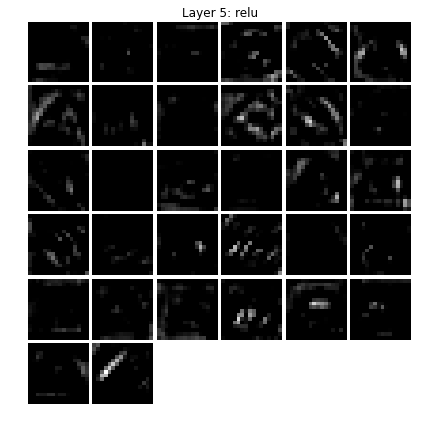

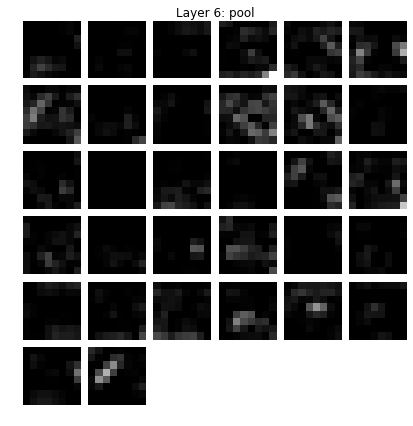

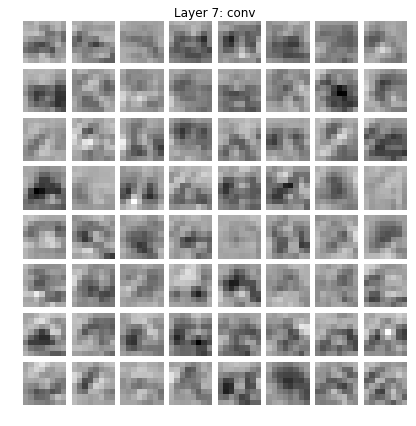

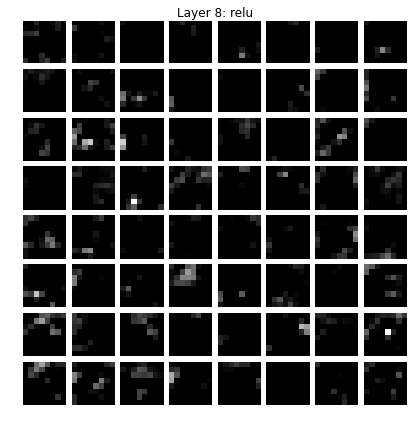

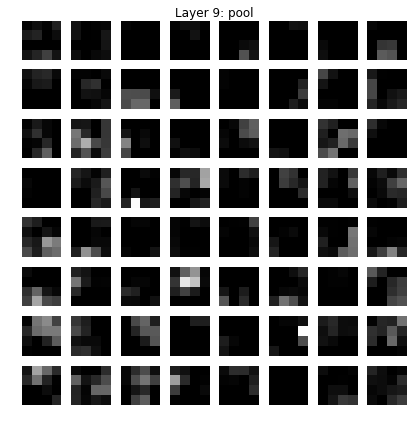

In [11]:
x = batches.next()['x']
x_ = np.transpose(x, (0, 2, 3, 1))
x_ = dp.misc.img_tile(dp.misc.img_stretch(x_), border_color=1.0)
plot_img(x_, title='Input image', figsize=(2,2))

for i in range(len(net.layers)):
    i = i+1
    net_ = dp.NeuralNetwork(net.layers[:i], loss=dp.loss.Loss())
    net_._setup(batches_input.x_shape)
    y = net_.fprop(x)
    if y.ndim != 4:
        continue
    y = np.squeeze(y)
    
    img_tile = dp.misc.img_tile(dp.misc.img_stretch(y), border_color=1.0)
    plot_img(img_tile, title='Layer %i: %s' % (i, net_.layers[-1].name))